In [196]:
%pip install gdown
%pip install matplotlib
%pip install scikit-learn
%pip install opencv-python
%pip install tensorflow
%pip install keras
%pip install pandas
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')


In [198]:
!gdown 1pWcMgSYqCrijBPtaL0khMF_LAm6ubi-3

Downloading...
From (original): https://drive.google.com/uc?id=1pWcMgSYqCrijBPtaL0khMF_LAm6ubi-3
From (redirected): https://drive.google.com/uc?id=1pWcMgSYqCrijBPtaL0khMF_LAm6ubi-3&confirm=t&uuid=ff9514be-0f28-4e91-bea5-a7c212e7bbf3
To: c:\Users\57301\Documents\9no Semestre\PF\lung_colon_image_set.zip

  0%|          | 0.00/1.89G [00:00<?, ?B/s]
  0%|          | 524k/1.89G [00:00<18:46, 1.68MB/s]
  0%|          | 1.57M/1.89G [00:00<08:19, 3.78MB/s]
  0%|          | 3.67M/1.89G [00:00<04:26, 7.07MB/s]
  0%|          | 6.29M/1.89G [00:00<03:07, 10.0MB/s]
  0%|          | 8.39M/1.89G [00:00<02:50, 11.0MB/s]
  1%|          | 11.5M/1.89G [00:01<02:03, 15.3MB/s]
  1%|          | 13.6M/1.89G [00:01<02:10, 14.3MB/s]
  1%|          | 15.7M/1.89G [00:01<02:31, 12.4MB/s]
  1%|          | 17.3M/1.89G [00:01<02:50, 11.0MB/s]
  1%|          | 18.9M/1.89G [00:01<03:39, 8.50MB/s]
  1%|          | 19.9M/1.89G [00:02<03:37, 8.60MB/s]
  1%|          | 21.0M/1.89G [00:02<04:05, 7.59MB/s]
  1%|          | 

In [199]:
from zipfile import ZipFile

data_path = 'lung_colon_image_set.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
path = 'lung_colon_image_set/colon_image_sets'
classes = os.listdir(path)
classes

['colon_aca', 'colon_n']

In [200]:
IMG_SIZE = 128
SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 64

In [201]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
    	img = cv2.imread(image)

    	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


## División de datos y verificación de formas:

In [202]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


(8000, 128, 128, 3) (2000, 128, 128, 3)


In [203]:
gc.collect()

76115

In [204]:
from tensorflow.keras.applications.inception_v3 import InceptionV3   # type: ignore
pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)


In [205]:
for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [206]:

flattened_output = layers.Flatten()(last_output)

dense_1 = layers.Dense(64, activation='relu')(flattened_output)
batch_norm_1 = layers.BatchNormalization()(dense_1)
dropout_1 = layers.Dropout(0.6)(batch_norm_1)

dense_2 = layers.Dense(32, activation='relu')(dropout_1)
batch_norm_2 = layers.BatchNormalization()(dense_2)
dropout_2 = layers.Dropout(0.6)(batch_norm_2)

output_layer = layers.Dense(2, activation='sigmoid')(dropout_2)

model = keras.Model(inputs=pre_trained_model.input, outputs=output_layer)

adam_optimizer = keras.optimizers.Adam(learning_rate=0.00004)

model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [207]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.85:
            print('\n Como la validacion alcanzo una precision del 85%, se detuvo el entrenamiento.')
            self.model.stop_training = True
es = EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [es, myCallback(), checkpoint]


In [208]:
print(np.unique(Y, return_counts=True))


(array([0, 1]), array([5000, 5000], dtype=int64))


In [209]:
import winsound 
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, myCallback()])

   
winsound.Beep(1440, 2000)    

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6497 - loss: 0.8053 - val_accuracy: 0.6995 - val_loss: 0.8332
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7303 - loss: 0.6597 - val_accuracy: 0.7350 - val_loss: 0.6327
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7602 - loss: 0.5975 - val_accuracy: 0.6780 - val_loss: 0.6970
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7815 - loss: 0.5660 - val_accuracy: 0.8060 - val_loss: 0.4451
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.7889 - loss: 0.5369
 Como la validacion alcanzo una precision del 85%, se detuvo el entrenamiento.
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7890 - loss: 0.5368 - val_accuracy: 0.8570 - val_loss: 0.3884


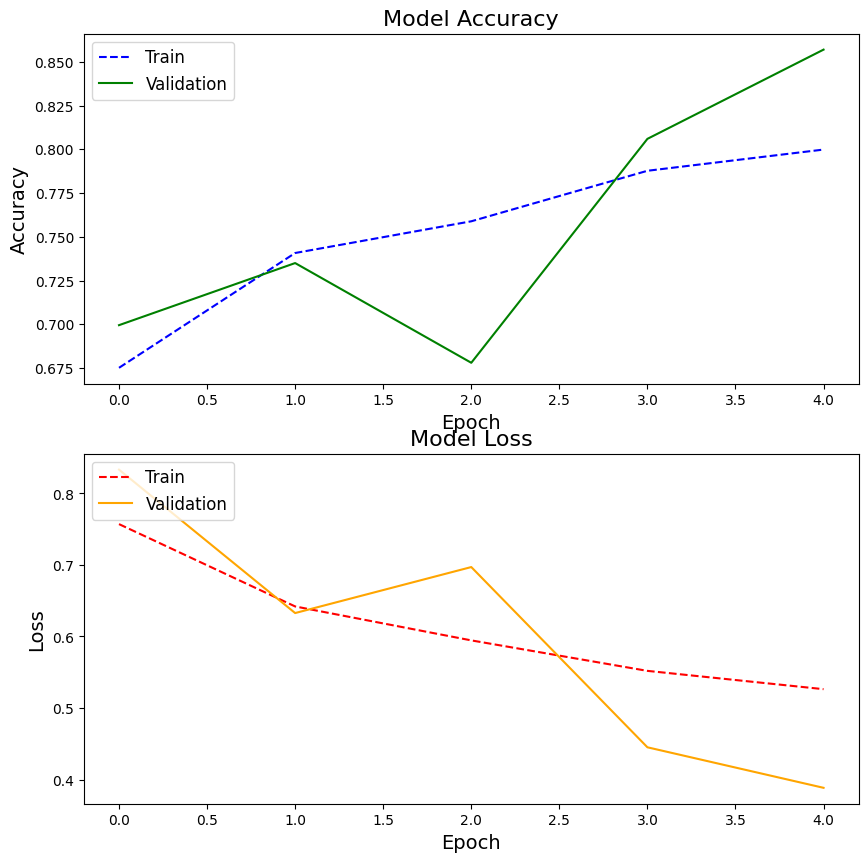

In [210]:
# Visualización de las métricas de entrenamiento
def plot_metrics(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='-')
    axs[0].set_title('Model Accuracy', fontsize=16)
    axs[0].set_ylabel('Accuracy', fontsize=14)
    axs[0].set_xlabel('Epoch', fontsize=14)
    axs[0].legend(['Train', 'Validation'], loc='upper left', fontsize=12)

    axs[1].plot(history.history['loss'], label='Train Loss', color='red', linestyle='--')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='-')
    axs[1].set_title('Model Loss', fontsize=16)
    axs[1].set_ylabel('Loss', fontsize=14)
    axs[1].set_xlabel('Epoch', fontsize=14)
    axs[1].legend(['Train', 'Validation'], loc='upper left', fontsize=12)
    plt.show()

plot_metrics(history)

In [211]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 583ms/step


In [212]:
print(metrics.confusion_matrix(Y_val, Y_pred))
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

[[732 247]
 [ 39 982]]
              precision    recall  f1-score   support

   colon_aca       0.95      0.75      0.84       979
     colon_n       0.80      0.96      0.87      1021

    accuracy                           0.86      2000
   macro avg       0.87      0.85      0.85      2000
weighted avg       0.87      0.86      0.86      2000



In [213]:
model.save('best_model.keras')
pd.DataFrame(history.history).to_csv('history.csv')
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)
np.save('Y_pred.npy', Y_pred)